In [9]:
import gzip
import json
import pandas as pd
import numpy as np

# Path to the dataset
train_data_path = "released_dataset/training-dataset.jsonl.gz"

# Initialize dictionaries
username2posts_train = dict()

# Function to calculate the average like count for a profile
def calculate_average_like_count(posts):
    total_likes = sum(post.get("like_count", 0) or 0 for post in posts)  # Treat null as 0
    post_count = len(posts)
    return total_likes / post_count if post_count > 0 else 0.0

# Function to calculate additional statistics for like counts
def calculate_like_stats(posts):
    like_counts = [post.get("like_count", 0) or 0 for post in posts]
    if not like_counts:
        return 0, 0, 0.0  # Return default values if no posts
    return min(like_counts), max(like_counts), np.std(like_counts)

# Load the data and enrich with additional attributes
with gzip.open(train_data_path, "rt") as fh:
    for line in fh:
        sample = json.loads(line)

        # Extract profile details
        profile = sample["profile"]
        username = profile["username"]
        follower_count = profile.get("follower_count", 0)
        following_count = profile.get("following_count", 0)

        # Calculate the average like count for the user's posts
        avg_like_count = calculate_average_like_count(sample["posts"])

        # Calculate additional like count statistics
        min_like_count, max_like_count, std_like_count = calculate_like_stats(sample["posts"])

        # Save posts and profile information
        username2posts_train[username] = {
            "username": username,
            "posts": sample["posts"],
            "follower_count": follower_count,
            "following_count": following_count,
            "avg_like_count": avg_like_count,  # Add average like count
            "min_like_count": min_like_count,  # Add minimum like count
            "max_like_count": max_like_count,  # Add maximum like count
            "std_like_count": std_like_count,  # Add standard deviation of like count
        }

# Create a DataFrame from the enriched data
rows = []
for username, details in username2posts_train.items():
    follower_count = details["follower_count"]
    following_count = details["following_count"]
    avg_like_count = details["avg_like_count"]
    min_like_count = details["min_like_count"]
    max_like_count = details["max_like_count"]
    std_like_count = details["std_like_count"]

    for post in details["posts"]:
        rows.append({
            "username": username,
            # "id": post["id"],
            "follower_count": follower_count,
            "following_count": following_count,
            "avg_like_count": avg_like_count,
            "min_like_count": min_like_count,
            "max_like_count": max_like_count,
            "std_like_count": std_like_count,
            "comments_count": post.get("comments_count", 0),
            "like_count": post.get("like_count", 0) or 0,  
        })

# Convert the list of rows to a DataFrame
posts_df = pd.DataFrame(rows)

In [10]:
import numpy as np
import pandas as pd

def random_sampling(posts_df, target_column='like_count'):
    """
    Perform random sampling within bins,
    and return three DataFrames: train, val, and test in a 60:20:20 ratio.

    Parameters:
    - posts_df: DataFrame containing the dataset with a target column.
    - target_column: String, the column name for the target variable.

    Returns:
    - train: DataFrame containing the training data (60% of the selected data).
    - val: DataFrame containing the validation data (20% of the selected data).
    - test: DataFrame containing the test data (20% of the selected data).
    """
    sampled_df = posts_df.copy()

    # Apply log transformation
    sampled_df['log_target'] = np.log1p(sampled_df[target_column])  

    # Define bins
    sampled_df['bin'] = pd.qcut(sampled_df['log_target'], q=30, labels=False)

    # Initialize lists to hold dataset
    train, val, test = [], [], []

    for _, group in sampled_df.groupby('bin'):
        # Shuffle the group randomly
        group = group.sample(frac=1, random_state=30).reset_index(drop=True)

        total_size = len(group)
        train_size = int(total_size * 0.6)
        val_size = int(total_size * 0.2)

        # Assign train, val, and test indices randomly
        train_indices = group.index[:train_size]
        val_indices = group.index[train_size:train_size + val_size]
        test_indices = group.index[train_size + val_size:]

        # Append the data to respective lists
        train.append(group.loc[train_indices])
        val.append(group.loc[val_indices])
        test.append(group.loc[test_indices])

    # Concatenate the results from all bins
    train = pd.concat(train).reset_index(drop=True)
    val = pd.concat(val).reset_index(drop=True)
    test = pd.concat(test).reset_index(drop=True)

    # Drop the temporary columns 
    train.drop(columns=['log_target', 'bin'], inplace=True)
    val.drop(columns=['log_target', 'bin'], inplace=True)
    test.drop(columns=['log_target', 'bin'], inplace=True)

    train = train.sample(frac=1, random_state=40).reset_index(drop=True)
    val = val.sample(frac=1, random_state=40).reset_index(drop=True)
    test = test.sample(frac=1, random_state=40).reset_index(drop=True)

    return train, val, test

train, val, test = random_sampling(posts_df, target_column='like_count')

## Calculate_metrics

In [11]:
def calculate_metrics(df):
    # Avoid division by zero 
    def safe_divide(numerator, denominator):
        return numerator / (denominator + 1e-9)

    # Calculate engagement_rate (like_count / follower_count)
    df['engagement_rate'] = safe_divide(df['like_count'], df['follower_count'])

    # Calculate like_per_follower (avg_like_count / follower_count)
    df['like_per_follower'] = safe_divide(df['avg_like_count'], df['follower_count'])

    # Calculate like_to_comment_ratio (avg_like_count / comments_count)
    df['like_to_comment_ratio'] = safe_divide(df['avg_like_count'], df['comments_count'])

    return df

posts_df = calculate_metrics(posts_df)
train = calculate_metrics(train)
val = calculate_metrics(val)
test = calculate_metrics(test)

## Taking Log

In [12]:
# Columns to apply log1p transformation
columns_to_log = ["like_count", "std_like_count", "max_like_count", "min_like_count", "avg_like_count", "follower_count", "following_count", "comments_count", "like_per_follower"]

# Apply log1p transformation to train, val, and test datasets
for col in columns_to_log:
    train[f"log_{col}"] = np.log1p(train[col])
    val[f"log_{col}"] = np.log1p(val[col])
    test[f"log_{col}"] = np.log1p(test[col])

# Setup the data for training
X_train = train.drop(columns=["log_like_count"])
y_train = train["log_like_count"]

X_val = val.drop(columns=["log_like_count"])
y_val = val["log_like_count"]

X_test = test.drop(columns=["log_like_count"])
y_test = test["log_like_count"]

X_train.drop(columns=columns_to_log, inplace=True)
X_val.drop(columns=columns_to_log, inplace=True)
X_test.drop(columns=columns_to_log, inplace=True)

X_train.drop(columns=['username'], inplace=True)
X_val.drop(columns=['username'], inplace=True)
X_test.drop(columns=['username'], inplace=True)

In [13]:
X_train.describe()

,engagement_rate,like_to_comment_ratio,log_std_like_count,log_max_like_count,log_min_like_count,log_avg_like_count,log_follower_count,log_following_count,log_comments_count,log_like_per_follower
count,112366.000000,1.123660e+05,112366.000000,112366.000000,112366.000000,112366.000000,112366.000000,112366.000000,112366.000000,112366.000000
mean,0.022820,1.507703e+11,4.692211,6.271992,3.389368,5.024473,9.740098,4.244449,1.390024,0.021748
std,0.176677,4.501269e+12,2.564087,2.613951,2.277389,2.409743,2.191720,2.333487,1.860658,0.044299
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.833213,0.000000,0.000000,0.000000
25%,0.002351,4.444286e+01,2.838695,4.442651,1.945910,3.367296,8.152774,2.197225,0.000000,0.003531
50%,0.007402,3.782484e+02,4.089040,5.688667,2.944439,4.454347,9.529303,4.330733,0.693147,0.009763
75%,0.020734,2.865714e+10,6.049283,7.626083,4.317488,6.124246,11.149945,6.311735,2.197225,0.023672
max,31.500000,3.193245e+14,14.328632,16.072383,13.147606,14.668476,19.556315,8.927181,13.561218,2.602889


## Density Plot

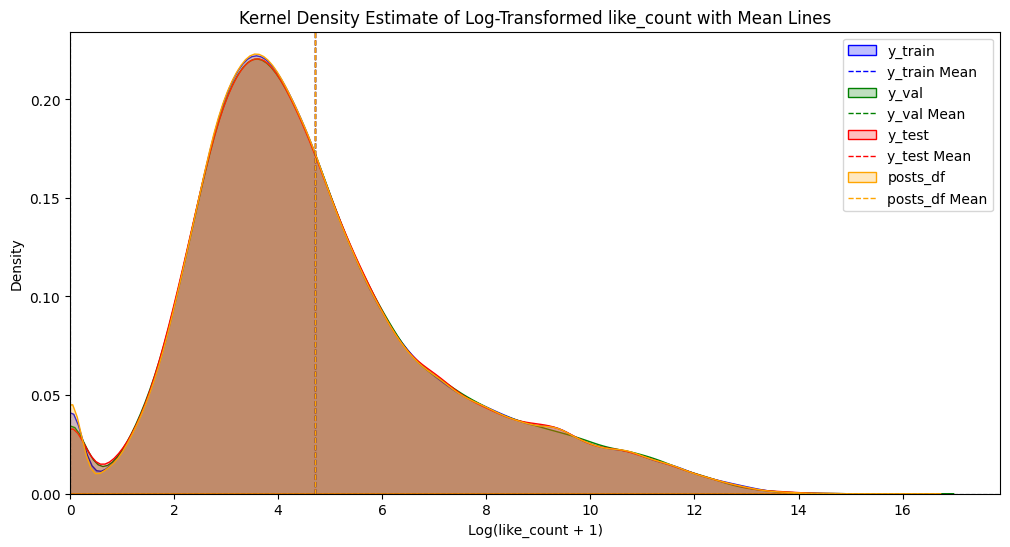

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

log_posts_df = np.log1p(posts_df["like_count"])

# Prepare the data 
data = {
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "posts_df": log_posts_df
}

# Define colors 
colors = {
    "y_train": "blue",
    "y_val": "green",
    "y_test": "red",
    "posts_df": "orange"
}

# Plot a KDE (Density Plot)
plt.figure(figsize=(12, 6))

# Plot the KDE and calculate the mean for each dataset
for label, dataset in data.items():
    sns.kdeplot(dataset, label=label, fill=True, color=colors[label])
    mean_value = np.mean(dataset)
    plt.axvline(mean_value, linestyle='--', linewidth=1, color=colors[label], label=f"{label} Mean")

# Add titles and labels
plt.title("Kernel Density Estimate of Log-Transformed like_count with Mean Lines")
plt.xlabel("Log(like_count + 1)")
plt.ylabel("Density")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.axvline(0, color='black', linewidth=0.8, linestyle='--') 
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.show()

## Random Forest hyper param tuneing

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# Optuna for hyperparameter tuning
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 70),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.01, 0.8),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 1500),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
    }

    model = RandomForestRegressor(**param, random_state=42, n_jobs=10)
    model.fit(X_train, y_train)

    # Predictions for validation set
    val_preds = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)

    # Predictions for training set
    train_preds = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)

    # Print metrics for each trial
    print(f"Trial {trial.number} Metrics:")
    print(f"  Training Set:  MSE = {train_mse:.4f}, MAE = {train_mae:.4f}, R2 = {train_r2:.4f}")
    print(f"  Validation Set: MSE = {val_mse:.4f}, MAE = {val_mae:.4f}, R2 = {val_r2:.4f}")

    # Return validation MSE for optimization
    return val_mse

# Setup the study
storage_url = "sqlite:///optuna_study.db"  

study = optuna.create_study(
    study_name="random_forest_regressionlog_randomSample_syndata1",   
    storage=storage_url,                   
    direction="minimize",                 
    load_if_exists=True                     
)

# Run the optimization
study.optimize(objective, n_trials=1, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params

[I 2025-01-12 20:23:34,938] Using an existing study with name 'random_forest_regressionlog_randomSample_syndata1' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 200 Metrics:
  Training Set:  MSE = 0.0198, MAE = 0.0922, R2 = 0.9968
  Validation Set: MSE = 0.0266, MAE = 0.1043, R2 = 0.9957
[I 2025-01-12 20:23:48,226] Trial 200 finished with value: 0.026635325445365194 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7349837055331322, 'n_estimators': 233, 'max_leaf_nodes': 1461, 'max_samples': 0.7741643215771011}. Best is trial 200 with value: 0.026635325445365194.


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import numpy as np
import pandas as pd


storage_url = "sqlite:///optuna_study.db" 

# Load the study 
loaded_study = optuna.load_study(study_name="random_forest_regressionlog_randomSample", storage=storage_url)
best_params = loaded_study.best_params

# Combine train and validation sets for training
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Initialize the model with the best parameters
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=10)
model.fit(X_train_val, y_train_val)

# Predict on sets
predictions_train_val = model.predict(X_train_val)
predictions_test = model.predict(X_test)

# Transform predictions and true values back to the original scale 
y_train_val_original = np.expm1(y_train_val)  
predictions_train_val_original = np.expm1(predictions_train_val)  
y_test_original = np.expm1(y_test)  
predictions_test_original = np.expm1(predictions_test) 

# Calculate metrics for the training+validation set
mse_train_val = mean_squared_error(y_train_val, predictions_train_val)
rmse_train_val = mse_train_val ** 0.5
mae_train_val = mean_absolute_error(y_train_val, predictions_train_val)
r2_train_val = r2_score(y_train_val, predictions_train_val)
sum_log_error_train_val = np.sum(np.abs(y_train_val - predictions_train_val))
mean_log_sum_error_train_val = sum_log_error_train_val / len(y_train_val)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, predictions_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)
sum_log_error_test = np.sum(np.abs(y_test - predictions_test))
mean_log_sum_error_test = sum_log_error_test / len(y_test)

# Calculate metrics for the training+validation set on the original scale
mse_train_val_original = mean_squared_error(y_train_val_original, predictions_train_val_original)
rmse_train_val_original = mse_train_val_original ** 0.5
mae_train_val_original = mean_absolute_error(y_train_val_original, predictions_train_val_original)
r2_train_val_original = r2_score(y_train_val_original, predictions_train_val_original)

# Calculate metrics for the test set on the original scale
mse_test_original = mean_squared_error(y_test_original, predictions_test_original)
rmse_test_original = mse_test_original ** 0.5
mae_test_original = mean_absolute_error(y_test_original, predictions_test_original)
r2_test_original = r2_score(y_test_original, predictions_test_original)

print("Metrics on training+validation set")
print(f" Log MSE: {mse_train_val:.4f}")
print(f" Log RMSE: {rmse_train_val:.4f}")
print(f" Log MAE: {mae_train_val:.4f}")
print(f" Log R2: {r2_train_val:.4f}")
print(f" Log Sum of Errors: {sum_log_error_train_val:.4f}")
print(f" Mean Log Sum of Errors: {mean_log_sum_error_train_val:.4f}")

print("\nMetrics on test set")
print(f" Log MSE: {mse_test:.4f}")
print(f" Log RMSE: {rmse_test:.4f}")
print(f" Log MAE: {mae_test:.4f}")
print(f" Log R2: {r2_test:.4f}")
print(f" Log Sum of Errors: {sum_log_error_test:.4f}")
print(f" Mean Log Sum of Errors: {mean_log_sum_error_test:.4f}")

print("--------------------------")

print("Metrics on training+validation set (original scale):")
print(f"  MSE: {mse_train_val_original:.4f}")
print(f"  RMSE: {rmse_train_val_original:.4f}")
print(f"  MAE: {mae_train_val_original:.4f}")
print(f"  R2: {r2_train_val_original:.4f}")

print("\nMetrics on test set (original scale):")
print(f"  MSE: {mse_test_original:.4f}")
print(f"  RMSE: {rmse_test_original:.4f}")
print(f"  MAE: {mae_test_original:.4f}")
print(f"  R2: {r2_test_original:.4f}")

Metrics on training+validation set
 Log MSE: 0.0194
 Log RMSE: 0.1393
 Log MAE: 0.0920
 Log R2: 0.9968
 Log Sum of Errors: 13775.4822
 Mean Log Sum of Errors: 0.0920

Metrics on test set
 Log MSE: 0.0262
 Log RMSE: 0.1617
 Log MAE: 0.1032
 Log R2: 0.9957
 Log Sum of Errors: 3867.4815
 Mean Log Sum of Errors: 0.1032
--------------------------
Metrics on training+validation set (original scale):
  MSE: 856021792.5120
  RMSE: 29257.8501
  MAE: 1243.6437
  R2: 0.7855

Metrics on test set (original scale):
  MSE: 348739843.2263
  RMSE: 18674.5775
  MAE: 1303.9334
  R2: 0.9098


## Error Analysis

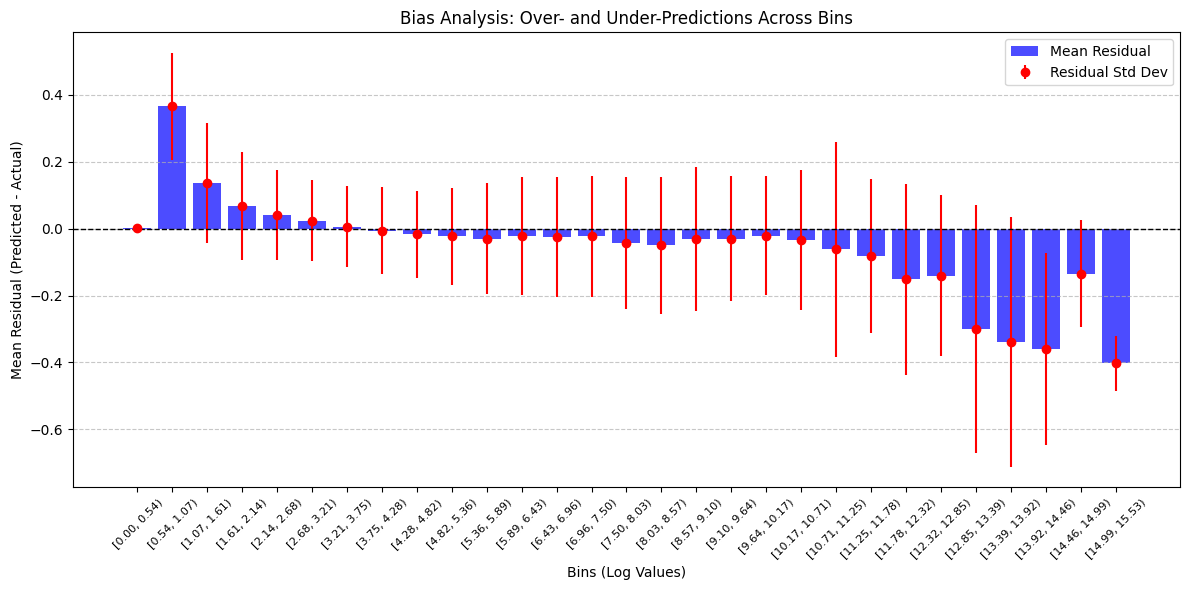

       bin       bin_range  mean_residual  std_residual  count
0    Bin 1    [0.00, 0.54)       0.002055      0.006569    926
1    Bin 2    [0.54, 1.07)       0.365600      0.159725    216
2    Bin 3    [1.07, 1.61)       0.135900      0.179606    668
3    Bin 4    [1.61, 2.14)       0.067938      0.162021   1836
4    Bin 5    [2.14, 2.68)       0.040379      0.134937   2881
5    Bin 6    [2.68, 3.21)       0.024051      0.122152   3935
6    Bin 7    [3.21, 3.75)       0.006396      0.120777   4627
7    Bin 8    [3.75, 4.28)      -0.005596      0.129432   4243
8    Bin 9    [4.28, 4.82)      -0.016934      0.129400   3673
9   Bin 10    [4.82, 5.36)      -0.022804      0.145244   2924
10  Bin 11    [5.36, 5.89)      -0.030228      0.166590   2225
11  Bin 12    [5.89, 6.43)      -0.023080      0.176190   1679
12  Bin 13    [6.43, 6.96)      -0.025123      0.179661   1345
13  Bin 14    [6.96, 7.50)      -0.023166      0.180754   1107
14  Bin 15    [7.50, 8.03)      -0.042563      0.196880

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

error_analysis_data = pd.DataFrame({
    "actual": y_test,
    "predicted": predictions_test,
    "residual": predictions_test - y_test  
})

# Define bins for log values
bins = np.linspace(error_analysis_data["actual"].min(), error_analysis_data["actual"].max(), 30)  
bin_labels = [f"Bin {i}" for i in range(1, len(bins))]

# Add a column to indicate the bin each value belongs to
error_analysis_data["bin"] = pd.cut(error_analysis_data["actual"], bins=bins, labels=bin_labels, include_lowest=True)

# Group by bins to calculate mean residuals
bias_per_bin = error_analysis_data.groupby("bin").agg(
    mean_residual=("residual", "mean"),
    std_residual=("residual", "std"),
    count=("residual", "size")
).reset_index()

# Add bin range information
bin_ranges = [f"[{bins[i]:.2f}, {bins[i+1]:.2f})" for i in range(len(bins) - 1)]
bias_per_bin["bin_range"] = bin_ranges

plt.figure(figsize=(12, 6))
plt.bar(bias_per_bin["bin_range"], bias_per_bin["mean_residual"], alpha=0.7, color="blue", label="Mean Residual")

# Add error bars for standard deviation of residuals
plt.errorbar(
    bias_per_bin["bin_range"],
    bias_per_bin["mean_residual"],
    yerr=bias_per_bin["std_residual"],
    fmt='o',
    color="red",
    label="Residual Std Dev"
)

# Customize the plot
plt.axhline(0, color="black", linestyle="--", linewidth=1)  
plt.title("Bias Analysis: Over- and Under-Predictions Across Bins")
plt.xlabel("Bins (Log Values)")
plt.ylabel("Mean Residual (Predicted - Actual)")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Display the bias analysis data
print(bias_per_bin[["bin", "bin_range", "mean_residual", "std_residual", "count"]])


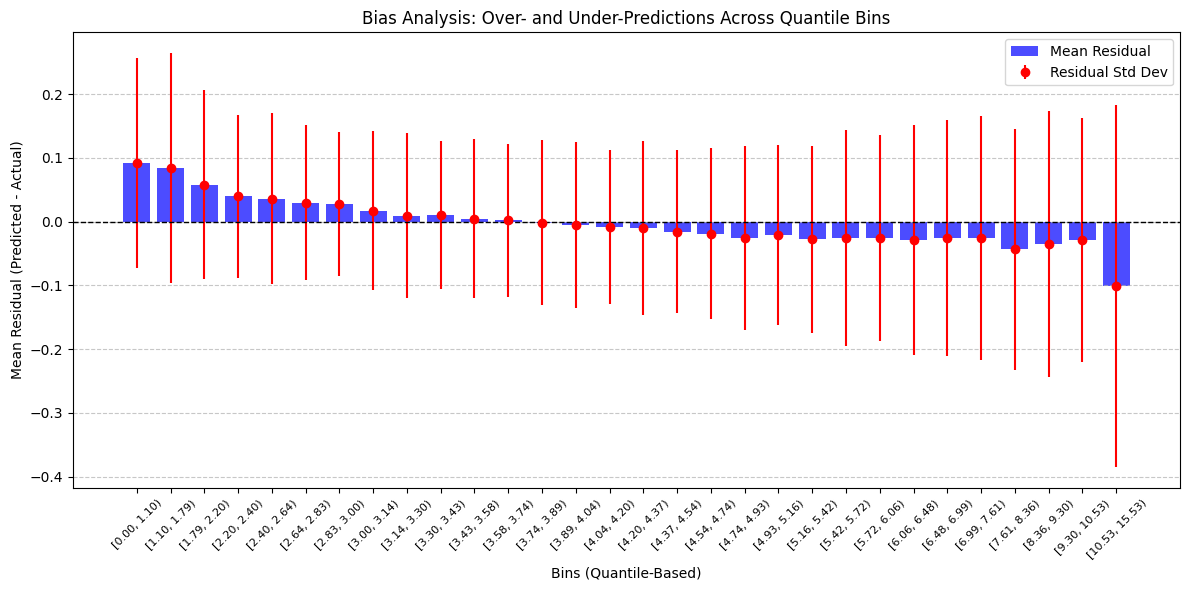

    bin       bin_range  mean_residual  std_residual  count
0     0    [0.00, 1.10)       0.091974      0.164504   1453
1     1    [1.10, 1.79)       0.084546      0.180074   1239
2     2    [1.79, 2.20)       0.058180      0.148116   1453
3     3    [2.20, 2.40)       0.039780      0.128240    968
4     4    [2.40, 2.64)       0.036270      0.134026   1414
5     5    [2.64, 2.83)       0.029849      0.121733   1315
6     6    [2.83, 3.00)       0.027753      0.112746   1208
7     7    [3.00, 3.14)       0.017530      0.124035   1082
8     8    [3.14, 3.30)       0.009094      0.129395   1263
9     9    [3.30, 3.43)       0.010589      0.115997   1153
10   10    [3.43, 3.58)       0.004539      0.124447   1248
11   11    [3.58, 3.74)       0.002418      0.119838   1293
12   12    [3.74, 3.89)      -0.001448      0.129475   1252
13   13    [3.89, 4.04)      -0.004773      0.130459   1222
14   14    [4.04, 4.20)      -0.008200      0.120492   1237
15   15    [4.20, 4.37)      -0.010084  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


error_analysis_data = pd.DataFrame({
    "actual": y_test,
    "predicted": predictions_test,
    "residual": predictions_test - y_test  
})

# Define bins for log values using quantiles
num_bins = 30  
bins = pd.qcut(
    error_analysis_data["actual"], q=num_bins, labels=False, duplicates="drop", retbins=True
)
error_analysis_data["bin"] = bins[0]  
bin_edges = bins[1] 

# Group by bins to calculate mean residuals
bias_per_bin = error_analysis_data.groupby("bin").agg(
    mean_residual=("residual", "mean"),
    std_residual=("residual", "std"),
    count=("residual", "size")
).reset_index()

# Add bin range information
bin_ranges = [f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f})" for i in range(len(bin_edges) - 1)]
bias_per_bin["bin_range"] = bin_ranges

plt.figure(figsize=(12, 6))

# Plot mean residuals
plt.bar(bias_per_bin["bin_range"], bias_per_bin["mean_residual"], alpha=0.7, color="blue", label="Mean Residual")

# Add error bars for standard deviation of residuals
plt.errorbar(
    bias_per_bin["bin_range"],
    bias_per_bin["mean_residual"],
    yerr=bias_per_bin["std_residual"],
    fmt='o',
    color="red",
    label="Residual Std Dev"
)

# Customize the plot
plt.axhline(0, color="black", linestyle="--", linewidth=1)  
plt.title("Bias Analysis: Over- and Under-Predictions Across Quantile Bins")
plt.xlabel("Bins (Quantile-Based)")
plt.ylabel("Mean Residual (Predicted - Actual)")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

# Display the bias analysis data
print(bias_per_bin[["bin", "bin_range", "mean_residual", "std_residual", "count"]])


## Adaptive Boosting

In [26]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import numpy as np

# Define bin edges and residual-based weights
bin_edges = [0.00, 0.54, 1.07, 1.61, 2.14, 2.68, 3.21, 3.75, 4.28, 4.82, 
             5.36, 5.89, 6.43, 6.96, 7.50, 8.03, 8.57, 9.10, 9.64, 10.17, 
             10.71, 11.25, 11.78, 12.32, 12.85, 13.39, 13.92, 14.46, 14.99, 15.53]

bin_residuals = [0.003418, 0.457094, 0.185310, 0.090665, 0.050145, 0.030696,
                 0.008872, -0.006180, -0.021552, -0.031738, -0.033739, -0.026770,
                 -0.018808, -0.007796, -0.032377, -0.075336, -0.056218, -0.059912,
                 -0.030982, -0.070924, -0.091047, -0.073294, -0.111272, -0.116180,
                 -0.218315, -0.303804, -0.226357, -0.107832, -0.114840]
bin_weights = np.abs(bin_residuals) / np.max(np.abs(bin_residuals))

# Function to assign weights to each sample
def assign_weights(y, bin_edges, bin_weights):
    weights = np.zeros_like(y, dtype=float)
    for i, (low, high) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        mask = (y >= low) & (y < high)
        weights[mask] = bin_weights[i]
    return weights

# Assign weights to training samples
sample_weights = assign_weights(y_train, bin_edges, bin_weights)

# Define the Optuna function for tuning
def objective(trial):
    # Define the hyperparameters
    param = {
        'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', 3, 70),
        'base_estimator__min_samples_split': trial.suggest_int('base_estimator__min_samples_split', 2, 50),
        'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', 1, 20),
        'base_estimator__max_features': trial.suggest_float('base_estimator__max_features', 0.01, 0.8),
        'base_estimator__max_leaf_nodes': trial.suggest_int('base_estimator__max_leaf_nodes', 10, 1500),
        'base_estimator__max_samples': trial.suggest_float('base_estimator__max_samples', 0.1, 1.0),
        'base_estimator__n_estimators': trial.suggest_int('base_estimator__n_estimators', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0)
    }

    # Create the Random Forest model
    base_estimator = RandomForestRegressor(
        max_depth=param['base_estimator__max_depth'],
        min_samples_split=param['base_estimator__min_samples_split'],
        min_samples_leaf=param['base_estimator__min_samples_leaf'],
        max_features=param['base_estimator__max_features'],
        max_leaf_nodes=param['base_estimator__max_leaf_nodes'],
        max_samples=param['base_estimator__max_samples'],
        n_estimators=param['base_estimator__n_estimators'],
        random_state=42, n_jobs=-1
    )

    # Create the AdaBoost model with Random Forest model
    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=param['n_estimators'],
        learning_rate=param['learning_rate'],
        random_state=42
    )

    # Train the model 
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Make predictions on the training set
    train_preds = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)

    # Make predictions on the validation set
    val_preds = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)

    # Print metrics 
    print(f"Trial {trial.number} Metrics:")
    print(f"  Training Set:  MSE = {train_mse:.4f}, MAE = {train_mae:.4f}, R2 = {train_r2:.4f}")
    print(f"  Validation Set: MSE = {val_mse:.4f}, MAE = {val_mae:.4f}, R2 = {val_r2:.4f}")

    return val_mse 


# Setup Optuna study
storage_url = "sqlite:///optuna_study.db"  

study = optuna.create_study(
    study_name="adaboost_random_forest_tuning",
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

# Run optimization
study.optimize(objective, n_trials=1, show_progress_bar=True)

# Print the best hyperparameters and performance
print("\nBest Hyperparameters:", study.best_params)
print("Best Validation MSE:", study.best_value)

[I 2025-01-12 20:25:58,238] Using an existing study with name 'adaboost_random_forest_tuning' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 18 Metrics:
  Training Set:  MSE = 0.0058, MAE = 0.0636, R2 = 0.9991
  Validation Set: MSE = 0.0104, MAE = 0.0727, R2 = 0.9983
[I 2025-01-12 20:30:32,560] Trial 18 finished with value: 0.010382789361566598 and parameters: {'base_estimator__max_depth': 50, 'base_estimator__min_samples_split': 29, 'base_estimator__min_samples_leaf': 3, 'base_estimator__max_features': 0.5400245435803146, 'base_estimator__max_leaf_nodes': 1067, 'base_estimator__max_samples': 0.997242851763503, 'base_estimator__n_estimators': 47, 'n_estimators': 339, 'learning_rate': 0.4029212896622343}. Best is trial 4 with value: 0.0018989207490848726.

Best Hyperparameters: {'base_estimator__max_depth': 58, 'base_estimator__min_samples_split': 33, 'base_estimator__min_samples_leaf': 7, 'base_estimator__max_features': 0.7937647132149322, 'base_estimator__max_leaf_nodes': 1295, 'base_estimator__max_samples': 0.9068201679643446, 'base_estimator__n_estimators': 21, 'n_estimators': 319, 'learning_rate': 0.88237566724814

In [27]:
# Load the study 
loaded_study = optuna.load_study(study_name="adaboost_random_forest_tuning", storage=storage_url)
best_params = study.best_params

# Create the final model with the best hyperparameters
final_base_estimator = RandomForestRegressor(
    max_depth=best_params['base_estimator__max_depth'],
    min_samples_split=best_params['base_estimator__min_samples_split'],
    min_samples_leaf=best_params['base_estimator__min_samples_leaf'],
    max_features=best_params['base_estimator__max_features'],
    max_leaf_nodes=best_params['base_estimator__max_leaf_nodes'],
    max_samples=best_params['base_estimator__max_samples'],
    n_estimators=best_params['base_estimator__n_estimators'],
    random_state=42, n_jobs=-1
)

final_model = AdaBoostRegressor(
    estimator=final_base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

final_model.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate on validation set
final_val_preds = final_model.predict(X_val)
final_val_mse = mean_squared_error(y_val, final_val_preds)
final_val_mae = mean_absolute_error(y_val, final_val_preds)
final_val_r2 = r2_score(y_val, final_val_preds)

print("\nFinal Model Metrics:")
print(f"  Validation MSE: {final_val_mse:.4f}")
print(f"  Validation MAE: {final_val_mae:.4f}")
print(f"  Validation R2: {final_val_r2:.4f}")


Final Model Metrics:
  Validation MSE: 0.0051
  Validation MAE: 0.0469
  Validation R2: 0.9992


In [28]:
# Load the study 
loaded_study = optuna.load_study(study_name="adaboost_random_forest_tuning", storage=storage_url)
best_params = study.best_params

# Create the final model with the best hyperparameters
final_base_estimator = RandomForestRegressor(
    max_depth=best_params['base_estimator__max_depth'],
    min_samples_split=best_params['base_estimator__min_samples_split'],
    min_samples_leaf=best_params['base_estimator__min_samples_leaf'],
    max_features=best_params['base_estimator__max_features'],
    max_leaf_nodes=best_params['base_estimator__max_leaf_nodes'],
    max_samples=best_params['base_estimator__max_samples'],
    n_estimators=best_params['base_estimator__n_estimators'],
    random_state=42, n_jobs=-1
)

final_model = AdaBoostRegressor(
    estimator=final_base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

sample_weights = assign_weights(y_train_val, bin_edges, bin_weights)

final_model.fit(X_train_val, y_train_val, sample_weight=sample_weights)

# Predict on sets
predictions_train_val = final_model.predict(X_train_val)
predictions_test = final_model.predict(X_test)

# Transform predictions and true values back to the original scale 
y_train_val_original = np.expm1(y_train_val)  
predictions_train_val_original = np.expm1(predictions_train_val)  
y_test_original = np.expm1(y_test)  
predictions_test_original = np.expm1(predictions_test) 

In [29]:
# Calculate metrics for the training+validation set
mse_train_val = mean_squared_error(y_train_val, predictions_train_val)
rmse_train_val = mse_train_val ** 0.5
mae_train_val = mean_absolute_error(y_train_val, predictions_train_val)
r2_train_val = r2_score(y_train_val, predictions_train_val)
sum_log_error_train_val = np.sum(np.abs(y_train_val - predictions_train_val))
mean_log_sum_error_train_val = sum_log_error_train_val / len(y_train_val)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, predictions_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)
sum_log_error_test = np.sum(np.abs(y_test - predictions_test))
mean_log_sum_error_test = sum_log_error_test / len(y_test)

# Calculate metrics for the training+validation set on the original scale
mse_train_val_original = mean_squared_error(y_train_val_original, predictions_train_val_original)
rmse_train_val_original = mse_train_val_original ** 0.5
mae_train_val_original = mean_absolute_error(y_train_val_original, predictions_train_val_original)
r2_train_val_original = r2_score(y_train_val_original, predictions_train_val_original)

# Calculate metrics for the test set on the original scale
mse_test_original = mean_squared_error(y_test_original, predictions_test_original)
rmse_test_original = mse_test_original ** 0.5
mae_test_original = mean_absolute_error(y_test_original, predictions_test_original)
r2_test_original = r2_score(y_test_original, predictions_test_original)

print("Metrics on training+validation set")
print(f" Log MSE: {mse_train_val:.4f}")
print(f" Log RMSE: {rmse_train_val:.4f}")
print(f" Log MAE: {mae_train_val:.4f}")
print(f" Log R2: {r2_train_val:.4f}")
print(f" Log Sum of Errors: {sum_log_error_train_val:.4f}")
print(f" Mean Log Sum of Errors: {mean_log_sum_error_train_val:.4f}")

print("\nMetrics on test set")
print(f" Log MSE: {mse_test:.4f}")
print(f" Log RMSE: {rmse_test:.4f}")
print(f" Log MAE: {mae_test:.4f}")
print(f" Log R2: {r2_test:.4f}")
print(f" Log Sum of Errors: {sum_log_error_test:.4f}")
print(f" Mean Log Sum of Errors: {mean_log_sum_error_test:.4f}")

print("--------------------------")

print("Metrics on training+validation set (original scale):")
print(f"  MSE: {mse_train_val_original:.4f}")
print(f"  RMSE: {rmse_train_val_original:.4f}")
print(f"  MAE: {mae_train_val_original:.4f}")
print(f"  R2: {r2_train_val_original:.4f}")

print("\nMetrics on test set (original scale):")
print(f"  MSE: {mse_test_original:.4f}")
print(f"  RMSE: {rmse_test_original:.4f}")
print(f"  MAE: {mae_test_original:.4f}")
print(f"  R2: {r2_test_original:.4f}")

Metrics on training+validation set
 Log MSE: 0.0025
 Log RMSE: 0.0504
 Log MAE: 0.0413
 Log R2: 0.9996
 Log Sum of Errors: 6181.1194
 Mean Log Sum of Errors: 0.0413

Metrics on test set
 Log MSE: 0.0052
 Log RMSE: 0.0724
 Log MAE: 0.0478
 Log R2: 0.9991
 Log Sum of Errors: 1792.3616
 Mean Log Sum of Errors: 0.0478
--------------------------
Metrics on training+validation set (original scale):
  MSE: 366394365.9085
  RMSE: 19141.4306
  MAE: 421.8472
  R2: 0.9082

Metrics on test set (original scale):
  MSE: 85235394.2039
  RMSE: 9232.3017
  MAE: 630.9474
  R2: 0.9780


## Create Output

In [31]:
import json
import pandas as pd

test_data_path = "released_dataset/test-regression-round3.jsonl"
extracted_data = []

with open(test_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        try:
            # Parse the JSON line
            data = json.loads(line.strip())
            
            # Extract the specified fields
            username = data.get("username", None)
            comments_count = data.get("comments_count", None)
            user_id = data.get("id", None)
            extracted_data.append({"username": username, "comments_count": comments_count, "id": user_id})

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

extracted_df = pd.DataFrame(extracted_data)

In [32]:
# Initialize lists to store extracted data
follower_counts = []
following_counts = []
avg_like_counts = []
min_like_counts = []
max_like_counts = []
std_like_counts = []
engagement_rates = []
like_per_followers = []
like_to_comment_ratios = []

for idx, row in extracted_df.iterrows():
    username = row["username"]
    
    # Find the username in the dictionary `username2posts_train`
    if username in username2posts_train:
        user_data = username2posts_train[username]
        
        # Append the relevant columns 
        follower_counts.append(user_data["follower_count"])
        following_counts.append(user_data["following_count"])
        avg_like_counts.append(user_data["avg_like_count"])
        min_like_counts.append(user_data["min_like_count"])
        max_like_counts.append(user_data["max_like_count"])
        std_like_counts.append(user_data["std_like_count"])
    else:
        # Print error if the username is not found 
        print(f"Error: Username '{username}' not found in username2posts_train.")
        
        follower_counts.append(0)
        following_counts.append(0)
        avg_like_counts.append(0)
        min_like_counts.append(0)
        max_like_counts.append(0)
        std_like_counts.append(0)

    # Check if the username is in `posts_df`
    if username in posts_df["username"].values:
        # Extract the matching rows for the username
        user_rows = posts_df[posts_df["username"] == username]
        
        # Calculate the mean of the required columns 
        engagement_rates.append(user_rows["engagement_rate"].mean())
        like_per_followers.append(user_rows["like_per_follower"].mean())
        like_to_comment_ratios.append(user_rows["like_to_comment_ratio"].mean())
    else:
        # Print an error if the username is not found
        print(f"Error: Username '{username}' not found in posts_df.")
        engagement_rates.append(0)
        like_per_followers.append(0)
        like_to_comment_ratios.append(0)

# Add the extracted data as new columns in extracted_df
extracted_df = extracted_df.assign(
    follower_count=follower_counts,
    following_count=following_counts,
    avg_like_count=avg_like_counts,
    min_like_count=min_like_counts,
    max_like_count=max_like_counts,
    std_like_count=std_like_counts,
    engagement_rate=engagement_rates,
    like_per_follower=like_per_followers,
    like_to_comment_ratio=like_to_comment_ratios
)

# Columns to apply the log1p transformation
columns_to_transform = [
    "std_like_count", "max_like_count", 
    "min_like_count", "avg_like_count", "follower_count", 
    "following_count", "comments_count", "like_per_follower"
]

# Apply log1p transformation
for col in columns_to_transform:
    if col in extracted_df.columns:
        extracted_df[f"log_{col}"] = np.log1p(extracted_df[col])
    else:
        print(f"Warning: Column '{col}' not found in extracted_df.")

# Drop the original columns
extracted_df.drop(columns=columns_to_transform, inplace=True)

# Drop the `username` column
extracted_df.drop(columns=["username"], inplace=True)

# Fix Column order 
column_order = [
    'id', 'engagement_rate', 'like_to_comment_ratio', 'log_std_like_count',
    'log_max_like_count', 'log_min_like_count', 'log_avg_like_count',
    'log_follower_count', 'log_following_count', 'log_comments_count',
    'log_like_per_follower'
]

# Reorder columns
extracted_df = extracted_df[column_order]

Error: Username 'touchdownistanbul' not found in posts_df.


In [34]:
import pandas as pd
import numpy as np
import json

# Combine train, validation, and test 
x_all = pd.concat([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test])

# Train the model on all data
final_model.fit(x_all, y_all)

features = extracted_df.drop(columns=["id"])  
ids = extracted_df["id"]  

# Make predictions 
predictions_final_log = model.predict(features)
predictions_final = np.expm1(predictions_final_log)
predictions_dict = dict(zip(ids, predictions_final))

# Save the predictions to a JSON file
output_file_path = "prediction-regression-round3.json"
with open(output_file_path, "w", encoding="utf-8") as f:
    json.dump(predictions_dict, f, ensure_ascii=False, indent=4)

print(f"Predictions successfully saved to {output_file_path}")

Predictions successfully saved to prediction-regression-round3.json
